<a href="https://colab.research.google.com/github/chamathjh/finance/blob/main/Mean_Variance_Portfolio_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mean Variance Portfolio Optimization

---

The mean-variance portfolio approach involves adjusting the weights of stocks in a portfolio to optimize the return relative to the risk. To achieve this, certain parameters must be estimated, including the expected return for each stock and the variance-covariance matrix of the stock returns. These parameters are necessary when assuming normal distribution or quadratic utility functions for investors. Once the parameters are determined, the portfolio variance is minimized given a target expected return, or equivalently, the expected return is maximized given the portfolio variance. This nonlinear optimization process results in the efficient frontier. Lastly, assuming a risk-free rate, the portfolio point on the frontier with the highest Sharpe ratio is identified.

##Installing Packages

In [ ]:
!pip install PyPortfolioOpt
!pip install yfinance
!pip install tabulate

##Load Python Libraries

In [ ]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import datetime as dt
import yfinance as yf
from matplotlib import pyplot as plt
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
from tabulate import tabulate
import requests
from bs4 import BeautifulSoup

##Establishing Model Environment

We start by defining the model environment, which includes retrieving stock price data from Yahoo Finance through yfinance API for the tickers mentioned below. Note that the adjusted closing price has been extracted to form the dataframe.

In [ ]:
#Defining a function to retrieve data from Yahoo Finance
def get_data(stocks,start_date,end_date):
  stock_data= yf.download(stocks, start=start_date, end=end_date)["Adj Close"]
  return stock_data

The period used for this model is dynamic as it is defined to retrive the latest available data from the exchange, starting from the **start_date** mentioned below.

In [ ]:
#Defining data period
start_date="2020-01-01"
end_date= dt.datetime.now().strftime("%Y-%m-%d")

The following stocks trading on Nasdaq Stockholm(OMXS30) were chosen for this exercise.
* AstraZeneca (AZN.ST)
* Atlas Copco AB (ATCO-B.ST)
* ABB Ltd. (ABB.ST)
* Investor AB (INVE-B.ST)
* AB Volvo (VOLV-B.ST)
* Nordea Bank ABP (NDA-SE.ST)

In [ ]:
#Defining the set of stock tickers
stocks = ["AZN.ST", "ATCO-B.ST", "ABB.ST", "INVE-B.ST", "VOLV-B.ST", "NDA-SE.ST"]

In [ ]:
#Downloading stock data
stock_df = get_data(stocks, start_date, end_date)
print(stock_df)

[*********************100%***********************]  6 of 6 completed
                ABB.ST   ATCO-B.ST       AZN.ST   INVE-B.ST   NDA-SE.ST  \
Date                                                                      
2020-01-02  224.803131   70.861885   935.406555  121.484901   75.626678   
2020-01-03  224.212296   69.697784   935.605164  120.137657   74.907249   
2020-01-07  226.378601   70.057610   938.781067  120.323479   74.771149   
2020-01-08  226.870956   69.951782   936.399109  120.277023   74.372543   
2020-01-09  226.378601   70.565567   943.644165  121.252609   74.625320   
...                ...         ...          ...         ...         ...   
2023-05-31         NaN  136.600006          NaN  220.649994  106.680000   
2023-06-01  400.899994  135.699997  1581.500000  221.750000  108.459999   
2023-06-02  403.500000  137.600006  1579.000000  221.800003  110.699997   
2023-06-05  406.799988  137.449997  1590.500000  220.350006  110.519997   
2023-06-07  408.000000  137.350

Plotting the stock price behavior during the observed period.

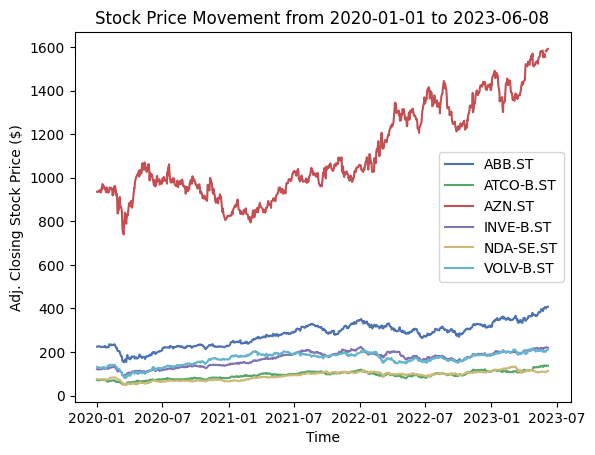

In [ ]:
plt.plot(stock_df.iloc[:,0:6])
plt.legend(stock_df)
plt.xlabel('Time')
plt.ylabel('Adj. Closing Stock Price ($)')
plt.title('Stock Price Movement from {} to {}'.format(start_date,end_date))
plt.show()

It's clearly visible from the graph AstraZeneca has been trading at a higher value than the rest, but has followed a similar path over the selected time period.

##Portfolio Optimization

Now we need to calculate stock returns using the `pct_change()` function

In [ ]:
#Calculating stock_returns
stock_returns = stock_df.pct_change()
print(stock_returns)

              ABB.ST  ATCO-B.ST    AZN.ST  INVE-B.ST  NDA-SE.ST  VOLV-B.ST
Date                                                                      
2020-01-02       NaN        NaN       NaN        NaN        NaN        NaN
2020-01-03 -0.002628  -0.016428  0.000212  -0.011090  -0.009513  -0.022084
2020-01-07  0.009662   0.005163  0.003394   0.001547  -0.001817   0.008588
2020-01-08  0.002175  -0.001511 -0.002537  -0.000386  -0.005331   0.005992
2020-01-09 -0.002170   0.008774  0.007737   0.008111   0.003399  -0.016928
...              ...        ...       ...        ...        ...        ...
2023-05-31  0.000000  -0.010862  0.000000   0.003411  -0.009287  -0.009889
2023-06-01 -0.011100  -0.006589  0.016715   0.004985   0.016685   0.012984
2023-06-02  0.006485   0.014002 -0.001581   0.000225   0.020653   0.024649
2023-06-05  0.008178  -0.001090  0.007283  -0.006537  -0.001626   0.007938
2023-06-07  0.002950  -0.000727  0.000629  -0.002950   0.024792   0.013365

[865 rows x 6 columns]


In [ ]:
#Calculating expected return for the stock data using the expected_return module in pypfopt library
mu= expected_returns.mean_historical_return(stock_df)
print(mu)

ABB.ST       0.189872
ATCO-B.ST    0.212913
AZN.ST       0.167666
INVE-B.ST    0.188634
NDA-SE.ST    0.125016
VOLV-B.ST    0.150759
dtype: float64


In [ ]:
#Deriving the covariance matrix
returns_cov = stock_returns.cov()*252
print(returns_cov)

             ABB.ST  ATCO-B.ST    AZN.ST  INVE-B.ST  NDA-SE.ST  VOLV-B.ST
ABB.ST     0.065782   0.055064  0.018392   0.045847   0.044360   0.052072
ATCO-B.ST  0.055064   0.112399  0.018364   0.063907   0.045193   0.065697
AZN.ST     0.018392   0.018364  0.066109   0.019749   0.012217   0.010271
INVE-B.ST  0.045847   0.063907  0.019749   0.067129   0.045742   0.054089
NDA-SE.ST  0.044360   0.045193  0.012217   0.045742   0.088059   0.056912
VOLV-B.ST  0.052072   0.065697  0.010271   0.054089   0.056912   0.101644


In [ ]:
#Deriving the correlation matrix
returns_corr = stock_returns.corr()
print(returns_corr)

             ABB.ST  ATCO-B.ST    AZN.ST  INVE-B.ST  NDA-SE.ST  VOLV-B.ST
ABB.ST     1.000000   0.640373  0.278904   0.689930   0.582839   0.636809
ATCO-B.ST  0.640373   1.000000  0.213040   0.735714   0.454260   0.614644
AZN.ST     0.278904   0.213040  1.000000   0.296457   0.160115   0.125293
INVE-B.ST  0.689930   0.735714  0.296457   1.000000   0.594936   0.654803
NDA-SE.ST  0.582839   0.454260  0.160115   0.594936   1.000000   0.601559
VOLV-B.ST  0.636809   0.614644  0.125293   0.654803   0.601559   1.000000


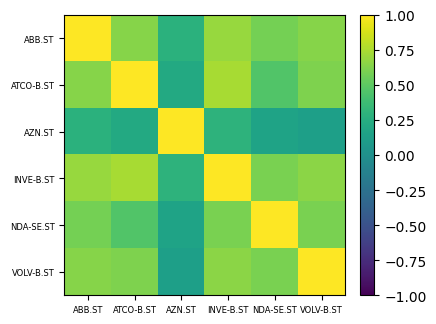

In [ ]:
#Heat map depicting correlation between stocks
fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(returns_corr, interpolation='nearest', vmin=-1, vmax=1)

stocks_order = np.arange(len(stocks))

#Aligning axes' names to the middle
ax.set_xticks(np.arange(len(stocks)))
ax.set_yticks(np.arange(len(stocks)))

#Setting the axes' names using stocks list
ax.set_xticklabels(returns_corr, fontsize=6)
ax.set_yticklabels(returns_corr, fontsize=6)

fig.colorbar(im, orientation='vertical', fraction = 0.0453)

The heat map shows that the stocks used in this exercise show a rather higher positive correlation with each other apart from AstraZeneca which displays a lower positive correlation. However, all the stocks show positive correlation which is expected as the stocks are driven by the market conditions and when the market is booming/falling, the stocks would more or less follow the same pattern. 

In [ ]:
#Retrieving riskbank rate using BeautifulSoup and requests
url="https://www.riksbank.se/en-gb/statistics/swestr/"
response= requests.get(url)

soup= BeautifulSoup(response.content, "html.parser")

riksbank_rate = soup.find("div", class_="data-block__value")

#Cleaning the retrieved text and converting the string value to a float
risk_free= float(riksbank_rate.text.strip().replace("%",""))/100
print(risk_free)

0.033929999999999995


Since we have taken stocks trading on OMXS30, the Swedish krona Short Term Rate (SWESTR) rate by the Swedish Riksbank has been used to calculate the optimized portfolio as the risk free rate. The above code snippet shows the method used in retrieving the SWESTR by webscraping the riksbank website using **BeautifulSoup** and **request** python libraries

In [ ]:
#Optimization of the portfolio inline with the maximum sharpe ratio
ef = EfficientFrontier(mu, returns_cov)
portfolio = ef.max_sharpe(risk_free)

portfolio_data = [{'Stock': asset, 'Allocation(%)': allocation*100} for asset, allocation in portfolio.items()]

print(tabulate(portfolio_data,headers= 'keys', tablefmt='github', showindex=False))

| Stock     |   Allocation(%) |
|-----------|-----------------|
| ABB.ST    |         31.193  |
| ATCO-B.ST |         10.2452 |
| AZN.ST    |         37.5896 |
| INVE-B.ST |         20.9723 |
| NDA-SE.ST |          0      |
| VOLV-B.ST |          0      |


In [ ]:
#Evaulating the performance of the portfolio
ef.portfolio_performance(verbose=True,risk_free_rate=risk_free)

Expected annual return: 18.4%
Annual volatility: 20.2%
Sharpe Ratio: 0.74


(0.1836255755091389, 0.20243428280447348, 0.7394773920469112)

The stocks are allocated among only four companies as the the return from the other two stocks are below par. Therefore, according to the given stocks and the time period, a maximum sharpe ratio of 0.74 can be obtained with an annual return of 18.4% along with a volatility of 20.2%.

###Applying constraints on the stock allocation

In case we want to set a maximum allocation to individual stocks to increase diversification, we could use the **weight_bounds** parameter within the **EfficientFrontier** function to define a minimum and a maximum allcation.

In [ ]:
#Applying a maximum constraint of 20% on each stock
ef2 = EfficientFrontier(mu, returns_cov, weight_bounds=(0,0.2))
portfolio2 = ef2.max_sharpe(risk_free)

portfolio2_data = [{'Stock': asset, 'Allocation(%)': allocation*100} for asset, allocation in portfolio2.items()]

print(tabulate(portfolio2_data,headers= 'keys', tablefmt='github', showindex=False))

| Stock     |   Allocation(%) |
|-----------|-----------------|
| ABB.ST    |        20       |
| ATCO-B.ST |        20       |
| AZN.ST    |        20       |
| INVE-B.ST |        20       |
| NDA-SE.ST |        10.0991  |
| VOLV-B.ST |         9.90089 |


In [ ]:
ef2.portfolio_performance(verbose=True,risk_free_rate=risk_free)

Expected annual return: 17.9%
Annual volatility: 21.5%
Sharpe Ratio: 0.68


(0.17936882815404304, 0.21533036575037903, 0.6754218228684128)

As expected the stocks with the highest return have been capped at 20% allocation and the remainder has been almost equally divided between Nordea Abp and AB Volvo. The performance has slightly decreased compared to the previous instance, with a marginal decrease in annual return and the sharpe ratio while the volatility has increased by 1.3 ppt.